In [1]:
import torch
import random
import pandas as pd
import numpy as np
import unicodedata
import re

import discopy
from discopy.symmetric import Ty, Box, Id, Functor
from discopy.grammar.pregroup import Word, Cup, Diagram
from discopy.drawing import Equation
from discopy.tensor import Dim, Tensor

from lambeq import BobcatParser
from lambeq import AtomicType, IQPAnsatz, remove_cups

In [2]:
SEED = 12
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

Dataset: https://github.com/CQCL/lambeq/tree/main/docs/examples/datasets

In [63]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append([t, 1-t]) # to transform 0 to |0> and 1 to |1>
            sentences.append(line[1:].strip())
    return labels, sentences


labels, data = read_data('corpuses/games_and_animals.txt')

In [163]:
contractions_dict = {"team's": "team", "day's": "day", "life's": "life", "nature's": "nature", "family's": "family",
                     "doctor's": "doctor", "school's": "school", "neighbor's": "neighbor", "cat's": "cat",
                     "I've": "I have", "I'm": "I am", "we've": "we have", "We've": "We have",
                     "can't": "cannot", "couldn't": "could not", "I've": "I have",
                     "He's": "He is", "he's": "he is", "She's": "She is", "she's": "she is",} 

contractions_re = re.compile('(%s)'%'|'.join(contractions_dict.keys()))
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

for i in range(len(data)):
    #data[i] = re.sub('[^A-Za-z ]', '', data[i])
    data[i] = expand_contractions(data[i])
    data[i] = data[i].strip()

In [64]:
data[0], labels[0]

('Sly fox hunts for food.', [1.0, 0.0])

In [65]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1, random_state=1)

train_data, dev_data, train_labels, dev_labels = train_test_split(train_data, train_labels, test_size=0.15, random_state=1)

In [66]:
len(data), len(train_data), len(dev_data), len(test_data)

(119, 90, 17, 12)

#### 1) First, define the atomic types "n" and "s".

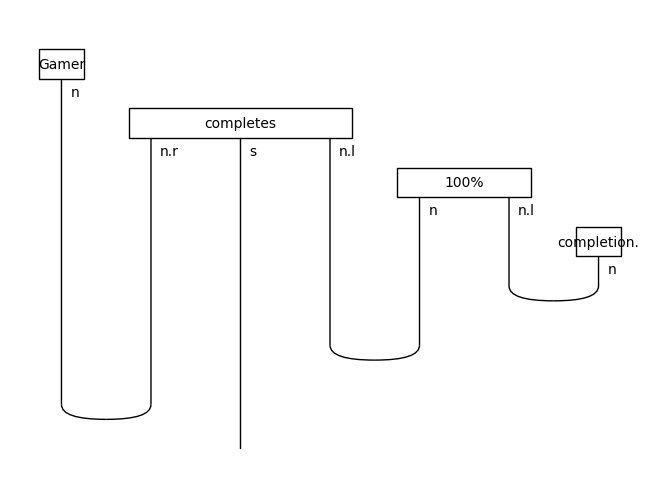

In [62]:
parser.sentence2diagram("Gamer completes 100% completion.").draw()

In [49]:
# Parsing using lambeq
parser = BobcatParser(verbose='text')

In [67]:
raw_train_diagrams = parser.sentences2diagrams(train_data)
raw_dev_diagrams = parser.sentences2diagrams(dev_data)
raw_test_diagrams = parser.sentences2diagrams(test_data)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


#### Create circuits

We will use an IQPAnsatz, where noun wires (n) are represented by a one-qubit system, and sentence wires (s) are discarded (since we deal with noun phrases).

Note that we remove the cups before parameterising the diagrams. By doing so, we reduce the number of post-selections, which makes the model computationally more efficient.

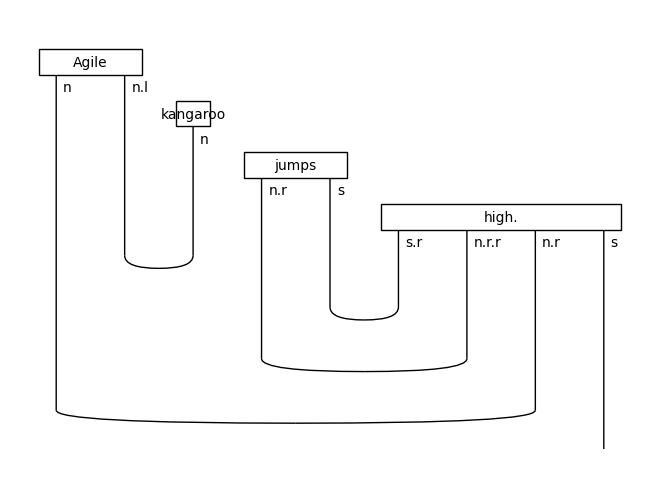

In [68]:
raw_test_diagrams[2].draw()

In [69]:
train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

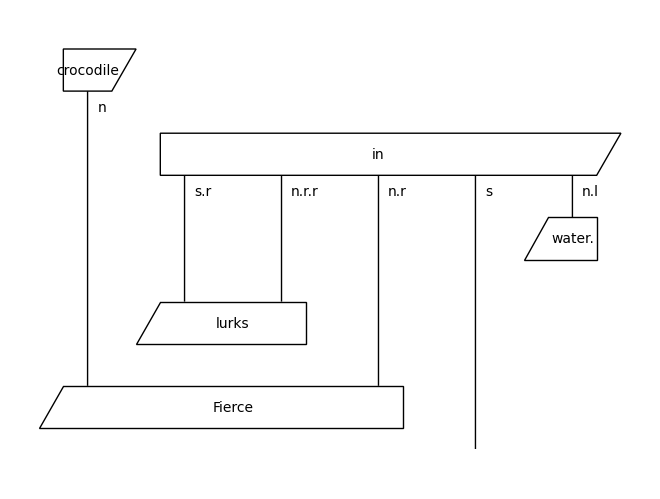

In [70]:
train_diagrams[2].draw()

In [74]:
N = AtomicType.NOUN
S = AtomicType.SENTENCE
P = AtomicType.PREPOSITIONAL_PHRASE
ansatz = IQPAnsatz({N:1, S:1, P:1}, n_layers = 1, n_single_qubit_params=3) 
train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits = [ansatz(diagram) for diagram in dev_diagrams]
test_circuits =  [ansatz(diagram)  for diagram in test_diagrams]

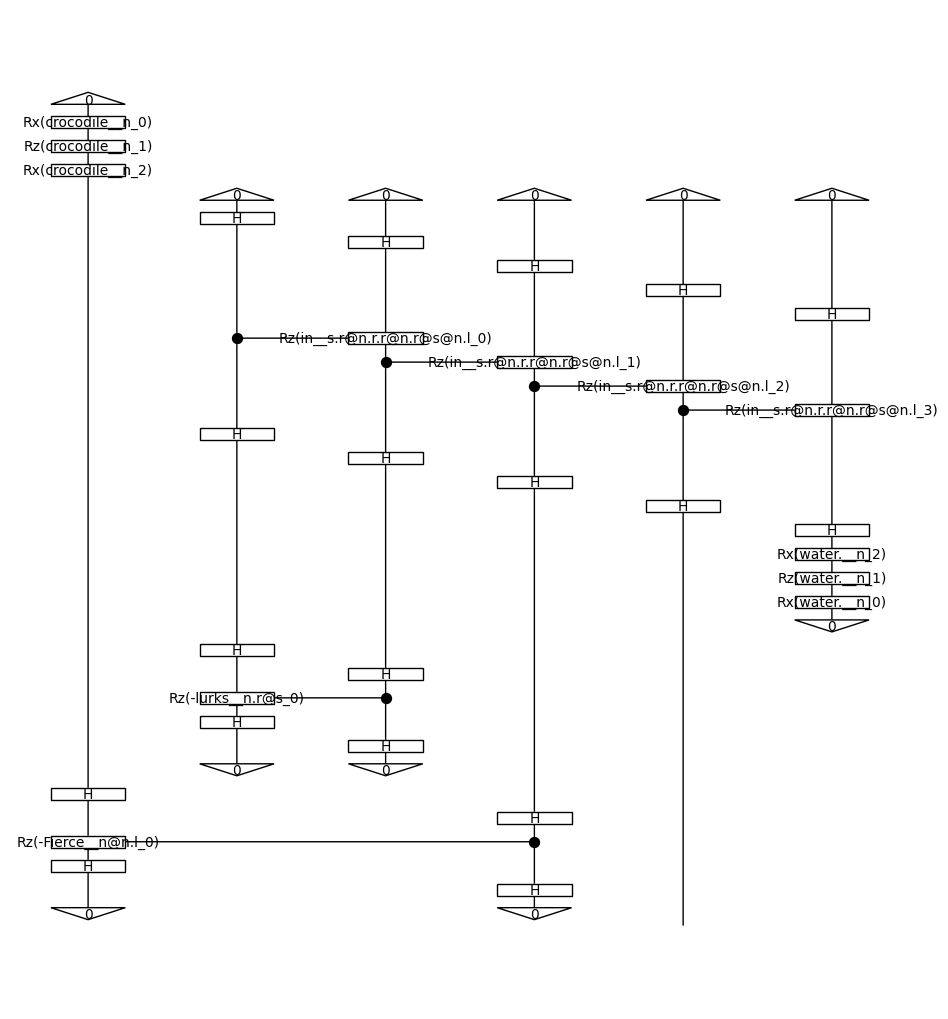

In [72]:
train_circuits[2].draw(figsize=(9, 10))

### Quantum model

### Hybrid model

In [75]:
BATCH_SIZE = 10
EPOCHS = 15
LEARNING_RATE = 0.001
SEED = 42

In [92]:
#!pip install PennyLane

In [29]:
from torch import nn
from lambeq import PennyLaneModel

In [76]:
all_circuits = train_circuits + dev_circuits + test_circuits
backend_config = {'backend': 'default.qubit'}
model = PennyLaneModel.from_diagrams(all_circuits, probabilities=True, normalize=True, backend_config=backend_config)
model.initialise_weights()

In [77]:
from lambeq import Dataset

train_dataset = Dataset(train_circuits,
                        train_labels,
                        batch_size=BATCH_SIZE)

dev_dataset = Dataset(dev_circuits, dev_labels)

In [78]:
def accuracy(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return nn.functional.mse_loss(y_hat, y)

In [79]:
from lambeq import PytorchTrainer

trainer = PytorchTrainer(
    model=model,
    loss_function=loss,
    optimizer=torch.optim.Adam,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    evaluate_functions={'acc': accuracy},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED)

In [80]:
trainer.fit(train_dataset, dev_dataset)

Epoch 1:   train/loss: 0.3726   valid/loss: 0.2428   train/acc: 0.5333   valid/acc: 0.7647
Epoch 2:   train/loss: 0.3265   valid/loss: 0.2438   train/acc: 0.5333   valid/acc: 0.7059
Epoch 3:   train/loss: 0.3328   valid/loss: 0.2446   train/acc: 0.5556   valid/acc: 0.7059
Epoch 4:   train/loss: 0.2877   valid/loss: 0.2452   train/acc: 0.5778   valid/acc: 0.7059
Epoch 5:   train/loss: 0.3986   valid/loss: 0.2465   train/acc: 0.6111   valid/acc: 0.7059
Epoch 6:   train/loss: 0.3887   valid/loss: 0.2475   train/acc: 0.6111   valid/acc: 0.7059
Epoch 7:   train/loss: 0.2352   valid/loss: 0.2486   train/acc: 0.6222   valid/acc: 0.7059
Epoch 8:   train/loss: 0.1407   valid/loss: 0.2493   train/acc: 0.6444   valid/acc: 0.7059
Epoch 9:   train/loss: 0.1507   valid/loss: 0.2497   train/acc: 0.6556   valid/acc: 0.7059
Epoch 10:  train/loss: 0.3360   valid/loss: 0.2504   train/acc: 0.6556   valid/acc: 0.7059
Epoch 11:  train/loss: 0.2058   valid/loss: 0.2515   train/acc: 0.6778   valid/acc: 0.7059

Final test accuracy: 0.8333333333333334


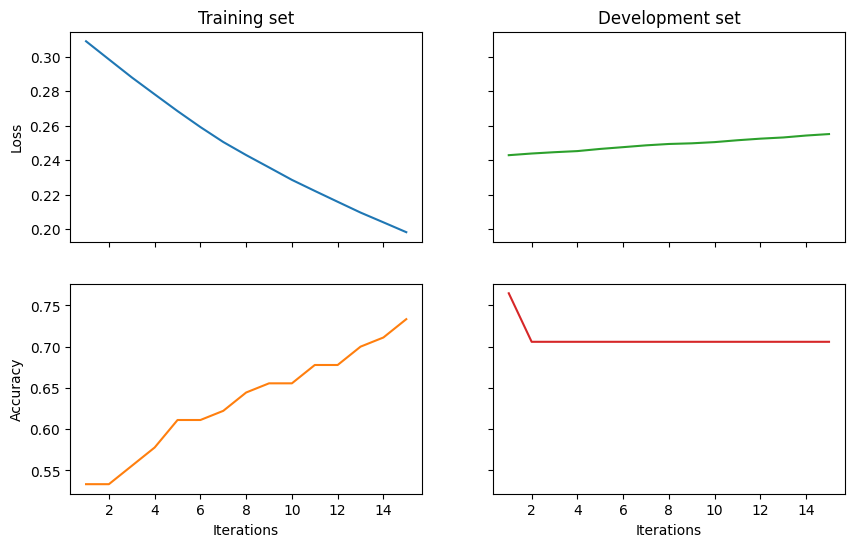

In [81]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey='row',
                                                     figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
pred = model(test_circuits)
labels = torch.tensor(test_labels)

print('Final test accuracy: {}'.format(accuracy(pred, labels)))

In [82]:
test_data

['Playful kitten chases butterflies.',
 'Pro gamer strategizes game.',
 'Agile kangaroo jumps high.',
 'Diligent honeybee pollinates flowers.',
 'Wise owl hunts under moonlight.',
 'Slithery snake glides silently.',
 'Energetic kangaroo hops through forest.',
 'Champion player practices skills.',
 'Wise tortoise wanders in desert.',
 'Curious monkey explores jungle.',
 'Clever crow solves complex puzzles.',
 'Expert gamer analyzes game mechanics.']

In [83]:
test_labels

[[1.0, 0.0],
 [0.0, 1.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [0.0, 1.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [0.0, 1.0]]

In [ ]:
#PennyLaneModel.get_diagram_output(test_diagrams[0])
model.get_diagram_output(test_circuits)